# CS166 First Project – Airport Security Queues

## Classes
The simulation was written in Python by defining four OOP classes. Event class creates each event that will be added to the Schedule class, such as adding passengers to the queue, screening passengers, and passengers going through additional screening. In the Event class, the function run runs the function associated with the Event object. Schedule class is responsible for implementing a schedule of such events in order of occurrence using a heap. The time for each event comes from probability distributions, as discussed in the Parameters and Assumptions section. The class Queue also implements each queue with its functions, such as adding people, starting and finishing service, and starting and finishing additional screening. The main attributes of this class are people in the queue, waiting time, and maximum queue length. Class Airport creates objects of the class Queue. It implements the overall features of an airport, such as adding passengers and managing the work of the senior security officer. Its main attributes are the Queue objects and the arrival distribution.

In [4]:
# The following code is adapted from the breakout activity of CS166 Session 3
import heapq
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    
    Attributes
    ----------
    self.timestamp
        the time in which each event happens
        
    self.function
        the function associated with the event
        
    self.args, self.kwargs
        remainging arguments associated with an event
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        When comparing two events, we will compare their timestamps
    
        Parameters
        ----------
        other
            the second Event object we are comparing to
        
        Returns
        -------
        bool
            True if our current event's timestamp is lower than the other's
            False otherwise
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run the function associated with the event 
        which should have an Schedule object as an input
        
        Parameters
        ----------
        schedule
            The schedule object we are adding the event to
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    
    Attributes
    ----------
        self.now
            The currente time of the schedule
            
        self.priority_queue
            The queue with the added events in relation to their timestamp

    '''
    
    def __init__(self):
        self.now = 0  
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        '''
        Creates an event at specific time and adds it to the self.priority_queue
        
        Parameters
        ----------
        timestamp
            The time in which that event happens
        
        function
            The function associated with that event
            
        *args, **kwargs
            Remaining parameters we want to include in the event

        '''
        event = Event(timestamp, function, *args, **kwargs)
        heapq.heappush(self.priority_queue, event)
    
    def add_event_after(self, interval, function, *args, **kwargs):
        '''
        Creates and event and adds it to self.priority_queue 
        in relation to the queue current time by calling self.add_event_at
        
        Parameters
        ----------
        interval
            The time until that event happens
        
        function
            The function associated with that event
            
        *args, **kwargs
            Remaining parameters we want to include in the event

        '''
        self.add_event_at(self.now + interval, function, *args, **kwargs)
        
    def next_event_time(self):
        '''
        Returns the timestamp of the next event to be run
        
        '''
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        '''
        Runs the first event (call the function associated with the event) 
        of the self.priority_queue and updates the current time of schedule
        
        Parameters
        ----------
        None        
        '''
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')

In [5]:
# Queue and Airport classes for an Exponential arrival time 
# and Truncated Normal service time

class Queue_MG1:
    '''
    Implement a queue inside the aiport with its security services, 
    such as adding people, start and finish service
    
    Attributes
    ----------
        self.service_distribution
            Store the type of distribution used for the time in the service station
            
        self.add_screening_distribution
            Store the type of distribution for the time of additional screening
            
        self.additional_screnning_prob
            Probability of the queue getting additional screening
            
        self.people_in_queue
            Updates the number of people in the queue
        
        self.people_being_served
            Updates the number of people currently being served
            
        self.queue_stopped
            Indicator for whether the queue is stopped because of additional screening
            

            
        self.arrival_time
            Store the arrival time for each passenger
            
        self.waiting_time
            Stores the waiting time for each passenger
            

    '''
    
    def __init__(self, service_distribution, add_screening_distribution, additional_screening_prob):
        '''
        Store the general service time for an M/G/1 queue
        
        '''
        
        self.service_distribution = service_distribution
        self.add_screening_distribution = add_screening_distribution
        self.additional_screening_prob = additional_screening_prob
        
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0
        
        # indicator if the queue is stopped because of the additional screening
        self.queue_stopped = 0
        self.arrival_time = []
        self.waiting_time = []
        self.max_queue_length = 0
         
    def __lt__(self, other):
        '''
        When comparing two queues, compare their lenghts
    
        Parameters
        ----------
        other
            the second Event object we are comparing to
        
        Returns
        -------
        bool
            True if our current event's timestamp is lower than the other's
            False otherwise
        '''
        
        return self.people_in_queue < other.people_in_queue


    def add_person(self, schedule, airport):
        '''
        Add the person to the queue 
        and serve person if the service station is empty
        '''
        self.people_in_queue += 1
        
        # update the self.max_queue_length
        if self.people_in_queue > self.max_queue_length:
            self.max_queue_length = self.people_in_queue
            
        # record the arrival time for each person
        heapq.heappush(self.arrival_time, schedule.now)

        if self.people_being_served < 1:
            # This person can be served immediately
            schedule.add_event_after(0, self.start_serving_person, airport)
            
    def start_serving_person(self, schedule, airport):
        '''
        Move the person from the queue to a server and 
        schedule the service end by generating a time from the self.service_distribution
        Generating a number from an Uniform distribution, if the number is
        less or equal to the probability of getting additional screening, the queue will be
        added to the senior office check queue 
        
        '''
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        # calculate waiting time as the difference between current and the earliest arrival time
        self.waiting_time.append(schedule.now - heapq.heappop(self.arrival_time))
        

        # Need additional screening 
        if np.random.random() <= self.additional_screening_prob:
            self.queue_stopped += 1
            # pass the arrival time to compute the waiting time
            airport.security_officer_queue.append(self)
        
        # No need for additional screening
        else:
            # Schedule the service end
            schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_person, airport)
            
            
    def finish_serving_person(self, schedule, airport):
        '''
        Remove the person from the server and schedule the next service
        if the queue is not empty
        '''
        self.people_being_served -= 1

        if self.people_in_queue > 0:
            # If there are more people in the queue so serve the next person
            schedule.add_event_after(0, self.start_serving_person, airport, )

            
    def start_additional_screening(self, schedule, airport):
        '''
        Start the additional screening by the security officer
        and add more time to the service
        '''
        
        additional_time = self.add_screening_distribution.rvs()
    
        # Schedule the end of the additional screening
        schedule.add_event_after(
            self.service_distribution.rvs() + additional_time,
            self.finish_additional_screening, airport)
    
    
    def finish_additional_screening(self, schedule, airport):
        '''
        Finish the additional screening and finish the total service
        
        '''
        self.queue_stopped -= 1
        airport.security_officer_busy = 0
        schedule.add_event_after(0, self.finish_serving_person, airport)
        

In [6]:
class Airport_MG1:
    '''
    Generate people arriving in the airport following an Exponential arrival distribution
    and creates queues with a truncated normal service distribution.
    Applies the senior security officer work by creating a list of suspecious queues
    and check them in order FIFO.
    
    Attributes
    ----------
        self.queue
            Create an object in the Queue class and store it
            
        self.arrival_distribution
            Store the arrival distribution to generate arrival times as an exponential distribution
        
        self.security_officer_queue
            Store the suspicious queues which the security officer needs to check
            
        self.security_officer_busy
            Indicator whether the security officer is free or not
            
        self.total_waiting_time
            Record the waiting time for each queue

    '''
    def __init__(self, arrival_rate, service_mean, 
                 service_st_dev, officer_mean, officer_st_dev, queues=1, additional_screening_prob=0.03):
        '''
        Creates a queue array to store all the queues and store the arrival distribution
        
        Parameters
        -------
        arrival_rate
            The rate of the exponentional distribution for the arrival time
            
        service_mean
            The mean of the service time following a Truncated Normal distribution
            
        service_st_dev
            The standard deviation of the service time following a Truncated Normal
            
        queues
            The number of queues of the airport (default=1)
            
        additional_screening_prob
            The probability of each passenger getting additional screening (default=0.03)
        '''
        
        service_distribution = sts.truncnorm(((0-service_mean)/service_st_dev),
                                             ((np.inf-service_mean)/service_st_dev),
                                             loc=service_mean, scale=service_st_dev)
        
        add_screening_distribution = sts.truncnorm(((0-officer_mean)/officer_st_dev),
                                                   ((np.inf-officer_mean)/officer_st_dev),
                                                   loc=officer_mean, scale=officer_st_dev)
        # create several queues
        self.queue = []
        for _ in range(queues):
            self.queue.append(Queue_MG1(service_distribution, add_screening_distribution, additional_screening_prob))
        
        self.queue = np.array(self.queue)
        
        self.arrival_distribution = sts.expon(scale = 1/arrival_rate)
        self.security_officer_queue = []
        self.security_officer_busy = 0

    def add_person(self, schedule):
        '''
        Add a person to the airport by picking the shortest queue to be joined
        Schedule when the next person is arriving       
        '''
    
        shortest_queue = min(self.queue)
        shortest_queue.add_person(schedule, self)
        # Schedule when to add another person
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)
        
        # check the security officer work
        self.security_officer(schedule)
        

    def run(self, schedule):
        '''
        Schedule when the first person arrives at the airport

        '''
        
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_person)
        
        
    def security_officer(self, schedule):
        '''
        Add a security officer to the airport
        It will delay the queue by a truncanted normal distribution
        '''

        while len(self.security_officer_queue) > 0 and self.security_officer_busy == 0:            
            queue_needed = self.security_officer_queue.pop(0)
            self.security_officer_busy = 1
            queue_needed.start_additional_screening(schedule, self)

def run_simulation_MG1(arrival_rate, service_mean, service_st_dev, 
                       officer_mean, officer_st_dev, run_until, queues):
    '''
    Create the schedule and airport objects and run until a certain time
    '''
    schedule = Schedule()
    airport = Airport_MG1(arrival_rate, service_mean, service_st_dev, officer_mean, officer_st_dev, queues)
    airport.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return airport

# Test case

By observing the correlation between the number of queues and their respective lengths, it is evident that an increased number of queues results in a proportionate reduction in queue length under consistent parameters. The test case reveals a consistent decrease factor, approximately 0.5, meaning that with each increment in the number of queues, the average queue length diminishes by half. This trend affirms the functionality of the code, assuming the scenario where individuals always join the shortest queue. Then, the amount of people in the airport will be distributed equally to each queue.


For 1 queues after 24.0 hours:
🔚There are 11845 people in queue 0.

For 2 queues after 24.0 hours:
🔚There are 4619 people in queue 0.
🔚There are 4618 people in queue 1.

For 3 queues after 24.0 hours:
🔚There are 2444 people in queue 0.
🔚There are 2444 people in queue 1.
🔚There are 2444 people in queue 2.

For 4 queues after 24.0 hours:
🔚There are 1313 people in queue 0.
🔚There are 1313 people in queue 1.
🔚There are 1313 people in queue 2.
🔚There are 1313 people in queue 3.

For 5 queues after 24.0 hours:
🔚There are 704 people in queue 0.
🔚There are 704 people in queue 1.
🔚There are 704 people in queue 2.
🔚There are 704 people in queue 3.
🔚There are 703 people in queue 4.

For 6 queues after 24.0 hours:
🔚There are 355 people in queue 0.
🔚There are 356 people in queue 1.
🔚There are 355 people in queue 2.
🔚There are 355 people in queue 3.
🔚There are 356 people in queue 4.
🔚There are 354 people in queue 5.

For 7 queues after 24.0 hours:
🔚There are 106 people in queue 0.
🔚There are 106 pe

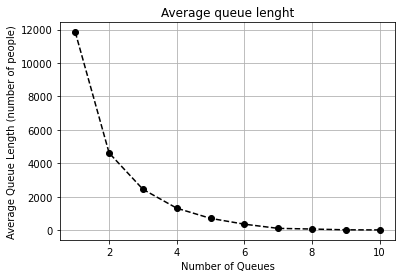

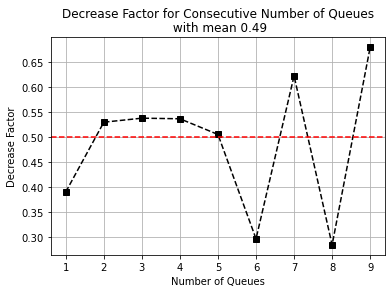

In [20]:
# Arrival Time parameters
arrival_rate = 10 # 10 travelers per minute

# Service Time Parameters
service_mean = 0.5 # min 
service_st_dev = 1/6 # min
max_queue = 10
total_queues = range(1, max_queue+1)
run_until = 1440  #in min
officer_mean = 2
officer_st_dev = 2

queue_length_average = []

# Run the simulation
for queues in total_queues:
    airport_simulation = run_simulation_MG1(arrival_rate, service_mean, service_st_dev, officer_mean, officer_st_dev, run_until, queues)
    print(f'\nFor {queues} queues after {round(run_until/60, 2)} hours:')
    queue_length_iteration = []
    for i in range(0, queues):
        print(f'🔚There are {airport_simulation.queue[i].people_in_queue} people in queue {i}.')
        queue_length_iteration.append(airport_simulation.queue[i].people_in_queue)
    queue_length_average.append(np.mean(queue_length_iteration))

factor = []
for i in range(len(queue_length_average[:-1])):
    factor.append(queue_length_average[i+1]/queue_length_average[i])

plt.plot(total_queues, queue_length_average, color='black', marker='o', linestyle='--')
plt.title('Average queue lenght')
plt.ylabel('Average Queue Length (number of people)')
plt.xlabel('Number of Queues')
plt.grid(True)
plt.show()

plt.plot(total_queues[:-1], factor, color='black', marker='s', linestyle='--')
plt.title(f'Decrease Factor for Consecutive Number of Queues\n with mean {round(np.mean(factor), 2)}')
plt.ylabel('Decrease Factor')
plt.xlabel('Number of Queues')
plt.axhline(0.5, linestyle='--', color='red')
plt.grid(True)
plt.show()


## Data Generation

We are simulating 100 trials for each number of queues from 1 to 15. For each trial, we store the values of waiting time, average queue length, and maximum queue length for all the queues in the airport after 24 hours of simulation timing. Then, we compute the expected value and a 95% confidence interval **waiting time, queue length and maximum queue length**. The simulation is set up in minutes. Therefore, the simulation will run until 1440 minutes or one day, after which the simulation stops, the values are computed and stored in lists. The results found are the following.

## Expected Value and Confidence Interval

Now, we compute the expected value and the confidence interval for each metric.

In [7]:
# Expected value and 95% confidence interval for the waiting time for increasing amount of queues:
## your code here
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Arrival Time parameters
arrival_rate = 10 # 10 travelers per minute
# Service Time Parameters
service_mean = 0.5 #min
service_st_dev = 1/6 # min
# Additional Screening Parameters
officer_mean = 2 # min 
officer_st_dev = 2 # min

max_queues = 15
num_queues = range(1, max_queues+1)
run_until = 1440 # in min = 1 dia

# Run the simulation
trials = 100

# list of lists
waiting_time_per_queue = []
queue_length_per_queue = []
max_queue_length_per_queue = []

for queue in tqdm(num_queues, desc='Outer Loop'):

    # store the average waiting time for 
    waiting_time_per_trial = []
    queue_length_per_trial = []
    max_queue_length_per_trial = []
    
    for _ in tqdm(range(trials), desc='Inner Loop', leave=True):
        airport_mean_waiting_time = []
        airport_queue_length = []
        airport_max_queue_length = []
        
        airport_simulation = run_simulation_MG1(arrival_rate, service_mean, service_st_dev, officer_mean, officer_st_dev, run_until, queues=queue)

        for i in range(queue):
            airport_mean_waiting_time.append(np.mean(airport_simulation.queue[i].waiting_time))
            airport_queue_length.append(airport_simulation.queue[i].people_in_queue)
            airport_max_queue_length.append(airport_simulation.queue[i].max_queue_length)

        waiting_time_per_trial.append(np.mean(airport_mean_waiting_time))
        queue_length_per_trial.append(np.mean(airport_queue_length))
        max_queue_length_per_trial.append(np.mean(airport_max_queue_length))
        
    waiting_time_per_queue.append(waiting_time_per_trial)
    queue_length_per_queue.append(queue_length_per_trial)
    max_queue_length_per_queue.append(max_queue_length_per_trial)

Outer Loop: 100%|██████████████████████████████████████████████████████████████████| 15/15 [9:59:28<00:00, 2397.88s/it]


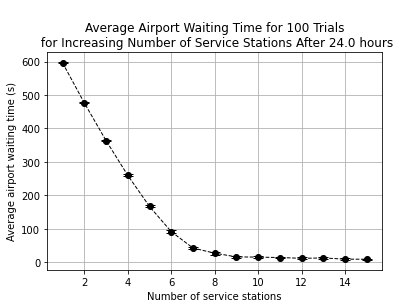

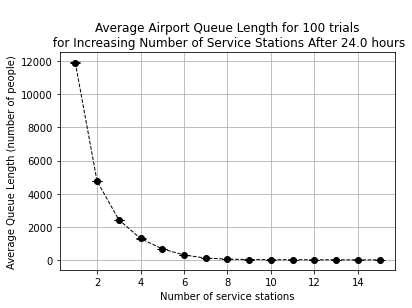

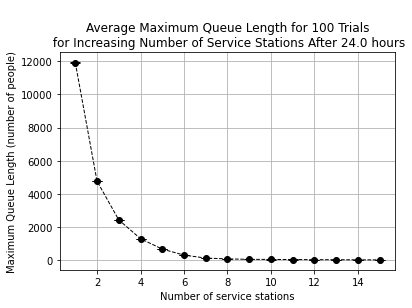

In [12]:
z = 1.96 # z-score

average_waiting_time = []
error_waiting_time = []

average_queue_length = []
error_queue_length = []

average_max_queue_length = []
error_max_queue_length = []
    
# Expected value and 95% Confidence Interval for each metric
for i in range(0, max_queues):
    # compute the statistics for each metric
    ## waiting time
    mean_waiting_time = np.mean(waiting_time_per_queue[i])
    t_waiting_time = sts.sem(waiting_time_per_queue[i]) # standard error
    
    conf_int_waiting_time = z*t_waiting_time # lenght of the confidence interval (error)

    average_waiting_time.append(round(mean_waiting_time, 2))
    error_waiting_time.append(round(conf_int_waiting_time, 2))

    ## queue length
    mean_queue_length = np.mean(queue_length_per_queue[i])
    t_queue_length = sts.sem(queue_length_per_queue[i]) # standard error
    conf_int_queue_length = z*t_queue_length # lenght of the confidence interval (error)
    
    average_queue_length.append(round(mean_queue_length, 2))
    error_queue_length.append(round(conf_int_queue_length, 2))
    
    ## max queue length
    mean_max_queue_length = np.mean(max_queue_length_per_queue[i])
    t_max_queue_length = sts.sem(max_queue_length_per_queue[i]) # standard error
    conf_int_max_queue_length = z*t_max_queue_length # lenght of the confidence interval (error)
    
    average_max_queue_length.append(round(mean_max_queue_length, 2))
    error_max_queue_length.append(round(conf_int_max_queue_length, 2))


# Plot error plot for waiting time for increasing number of queues

plt.errorbar(num_queues, average_waiting_time, 
           error_waiting_time, marker='o', color='black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel(f'Number of service stations')
plt.ylabel('Average airport waiting time (s)')
plt.title(f'\nAverage Airport Waiting Time for {trials} Trials' 
          f'\n for Increasing Number of Service Stations After {round(run_until/60, 2)} hours')
plt.grid(True)
plt.show()

# Queue Length 
plt.errorbar(num_queues, average_queue_length, 
           error_queue_length, marker='o', color='black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel(f'Number of service stations')
plt.ylabel('Average Queue Length (number of people)')
plt.title(f'\nAverage Airport Queue Length for {trials} trials' 
          f'\n for Increasing Number of Service Stations After {round(run_until/60, 2)} hours')
plt.grid(True)
plt.show()

# Max Queue Length
plt.errorbar(num_queues, average_max_queue_length, 
           error_max_queue_length, marker='o', color='black', capsize=5, linestyle='--', linewidth=1)
plt.xlabel(f'Number of service stations')
plt.ylabel('Maximum Queue Length (number of people)')
plt.title(f'\nAverage Maximum Queue Length for {trials} Trials' 
          f'\n for Increasing Number of Service Stations After {round(run_until/60, 2)} hours')
plt.grid(True)
plt.show()


## Result of Empirical Analysis

### Average Queue Length
There is significant decrease in the average queue length for increasing queues/service stations after 24 hours of simulation time. From 12000 customers, when there is only one queue, we decrease sharply to close to zero after implementing eight queues in the airport. Adding more queues does not significantly decrease the average length since it has reached its minimum. The bars are hard to see, given the narrow confidence interval caused by the large sample size (100 trials).

### Average Waiting Time
The average waiting time decreases approximately linearly from 600 to 100 after six queues. After that, the model assumes an exponential decrease that stabilizes after ten queues. The small confidence interval also is a reflection of the increased sample size. 

### Average Maximum Queue Length
Here, the average maximum queue length shown in Figure 5 has behavior that is very similar to the average queue length. This behavior can be caused by the constant increase of the queue length for increased running time due to the presence of senior security officers given the parameters defined, indicating that the maximum queue length at a particular time is the queue length at the same time since the queue is constantly growing. This indicates that the queue has not reached equilibrium after 24 hours (simulation time) or the equilibrium does not exist for increasing running time. However, we see that maximum queue length also decreases drastically for increasing the number of queues, stabilizing after 9 or 10 queues. Given that there is no precise theoretical formula we can use, we can compare this empirical behaviour to the theoretical values of the average queue length given the similar plot behavior. 

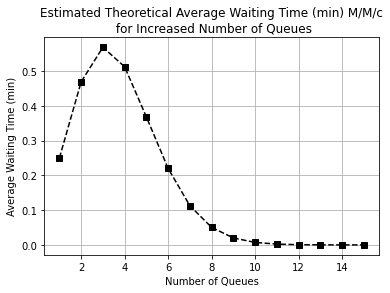

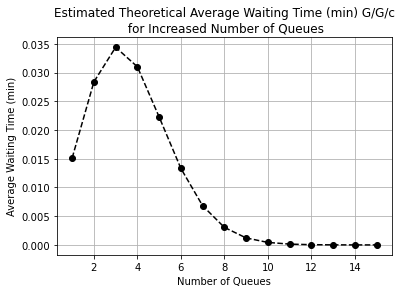

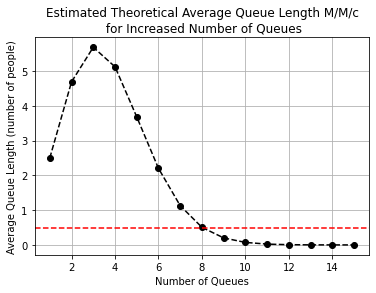

In [16]:
import math

lambd = 10 #min arrival rate
service_mean = 0.5 #min
sigma = 1/6 # variance of service
mu = 1/service_mean # service rate
c = 15 # number of queues >5
rho = lambd/(c*mu)

# Calculate P0
def P0(c, rho):
    k = 0
    for m in range(0, c):
        k += ((c*rho)**m)/math.factorial(m)

    return 1/(k + ((c*rho)**c)/(math.factorial(c)*(1-rho)))

# Average queue length
def Lq(rho, c, lambd):
    return (P0(c, rho)*(lambd/mu)**c * rho)/(math.factorial(c)*(1-rho)**2)

# Average waiting time M/M/c
def Wq(rho, c, lambd):
    return Lq(rho, c, lambd)/lambd

# Average Waiting Time G/G/c
def Wq_GGc(rho, c, lambd, sigma, mu):
    return Wq(rho, c, lambd) * ((1/lambd**2)**2/(1/lambd)**2 + sigma**2/(1/mu)**2)/2


theoretical_queue_length_MMc = []
theoretical_waiting_time_MMc = []
theoretical_waiting_time_GGc = []
queues = []

for i in range(1, c+1):
    queues.append(i)
    theoretical_queue_length_MMc.append(Lq(rho, i, lambd))
    theoretical_waiting_time_MMc.append(Wq(rho, i, lambd))
    theoretical_waiting_time_GGc.append(Wq_GGc(rho, i, lambd, sigma, mu))
    


plt.plot(queues, theoretical_waiting_time_MMc, color='black', marker='s', linestyle='--', label='Waiting Time (min)')
plt.title('Estimated Theoretical Average Waiting Time (min) M/M/c\n for Increased Number of Queues')
plt.ylabel('Average Waiting Time (min)')
plt.xlabel('Number of Queues')
plt.grid(True)
plt.show()

plt.plot(queues, theoretical_waiting_time_GGc, marker='o', color='black', linestyle='--', label='Queue Length')
plt.title('Estimated Theoretical Average Waiting Time (min) G/G/c\n for Increased Number of Queues')
plt.ylabel('Average Waiting Time (min)')
plt.xlabel('Number of Queues')
plt.grid(True)
plt.show()


plt.plot(queues, theoretical_queue_length_MMc, color='black', marker='o', linestyle='--', label='Queue Length')
plt.title('Estimated Theoretical Average Queue Length M/M/c\n for Increased Number of Queues')
plt.ylabel('Average Queue Length (number of people)')
plt.xlabel('Number of Queues')
plt.grid(True)
plt.show()

## Theoretical Analysis

The queue type of this simulation is M/G/c, indicating that the interarrival time comes from an exponential distribution, a truncated normal distribution generates the service time, and there are c service stations in the simulations. There are also c queues, each with a station at the end. The performance metrics for this type of queue are still an open problem. Therefore, the metrics used here are approximations found by some authors and approximations from other types of queues. The approximation is not actually precise since no senior security officer is considered in the queue theory, making the actual metrics harder to be computed theoretically. For this assignment, the metrics are computed as recommended by the class notes of A. Gosavi. He assumes a homogeneous case with multiple parallel servers and one single waiting queue. This assumption is valid in our simulation since the arrival distribution for each queue is identical, and each person is only joining the shortest queue, indicating a constant approximated queue length.

## Conclusion 

Given the set assumption and approximations for this simulation, we can infer that the minimum number of queues that drastically decreases the waiting time, queue length, and maximum queue length is 10, as discussed extensively in the previous section. Above this value, those metrics are not impacted, indicating that the system has reached its minimum equilibrium.

One significant constraint of the simulation is its extensive running time due to nested loops and high running until simulation parameter value. Further improvements would be a better use of data structures such as heaps instead of queues to store and retrieve values. Here, we use approximations for the theoretical calculations of the metrics, which do not account for the presence of the senior security officer. We are using approximations mainly due to the need for simpler and better formulas for calculating queue performances for queues M/G/c in the mathematical realm. Better predictions would benefit from the theoretical formulation of such metrics. 